In [1]:
import pandas as pd

In [2]:
path = '../data/epic-kitchens-100-annotations/filtered_train.pkl'

df = pd.read_pickle(path)
df.head()

,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes,duration_in_s,precs,posts,precs_vec,posts_vec
narration_id,,,,,,,,,,,,,,,,,,,
P01_01_136,P01,P01_01,00:10:39.580,00:10:41.81,00:10:42.83,38508,38569,throw carrot into bin,throw-into,13,carrot,41,"[carrot, bin]","[41, 36]",1.02,"[in-hand, not-thrown]","[thrown, not-in-hand]","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
P01_01_139,P01,P01_01,00:10:50.470,00:10:52.77,00:10:53.83,39166,39229,throw carrot into bin,throw-into,13,carrot,41,"[carrot, bin]","[41, 36]",1.06,"[in-hand, not-thrown]","[thrown, not-in-hand]","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
P01_01_197,P01,P01_01,00:15:10.040,00:15:09.33,00:15:11.48,54559,54688,throw something into the bin,throw-into,13,bin,36,[bin],[36],2.15,"[in-hand, not-thrown]","[thrown, not-in-hand]","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
P01_01_198,P01,P01_01,00:15:07.820,00:15:11.43,00:15:13.59,54685,54815,throw something into the bin,throw-into,13,bin,36,[bin],[36],2.16,"[in-hand, not-thrown]","[thrown, not-in-hand]","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
P01_01_199,P01,P01_01,00:15:15.490,00:15:17.61,00:15:18.43,55056,55105,throw tupperware container into the bin,throw-into,13,container:tupperware,23,"[container:tupperware, bin]","[23, 36]",0.82,"[in-hand, not-thrown]","[thrown, not-in-hand]","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


In [3]:
verb_counts = pd.DataFrame(df['verb_class'].value_counts())
verb_counts_dict = verb_counts.to_dict()['count']
verb_counts_dict

{13: 783, 15: 570, 30: 199, 32: 147, 58: 75, 49: 64, 62: 43, 75: 28}

In [4]:
max_verb_class = max(verb_counts_dict, key=verb_counts_dict.get)
max_value = verb_counts_dict[max_verb_class]
max_verb_class, max_value

(13, 783)

In [5]:
import math
import numpy as np

verb_counts['to_augment'] = max_value - verb_counts['count']
verb_counts['t_per_sample'] = verb_counts['to_augment'] / verb_counts['count']

t_by_class = verb_counts.to_dict(orient='index')
t_by_class

{13: {'count': 783, 'to_augment': 0, 't_per_sample': 0.0},
 15: {'count': 570, 'to_augment': 213, 't_per_sample': 0.3736842105263158},
 30: {'count': 199, 'to_augment': 584, 't_per_sample': 2.9346733668341707},
 32: {'count': 147, 'to_augment': 636, 't_per_sample': 4.326530612244898},
 58: {'count': 75, 'to_augment': 708, 't_per_sample': 9.44},
 49: {'count': 64, 'to_augment': 719, 't_per_sample': 11.234375},
 62: {'count': 43, 'to_augment': 740, 't_per_sample': 17.209302325581394},
 75: {'count': 28, 'to_augment': 755, 't_per_sample': 26.964285714285715}}

In [6]:
transforms = [lambda _: "t1", lambda _: "t2", lambda _: "t3", lambda _: "t3", lambda _: "t4", lambda _: "t5"]

In [7]:
def augment_data(df: pd.DataFrame) -> pd.DataFrame:
    df['transformation'] = None
    df['t_params'] = None

    augmented_rows = []
    for _, row in df.iterrows():
        rows = [row.to_dict()]
        c = row['verb_class']
        t_per_row = t_by_class[c]['t_per_sample']
        
        if 0 < t_per_row <= 1:
            augment = np.random.binomial(n=1, p=t_per_row)
            if augment:
                transformation = np.random.choice(transforms)
                aug_row = row.copy()
                aug_row['transformation'] = transformation
                aug_row['t_params'] = np.random.choice(range(19))

                rows.append(aug_row)

        elif t_per_row > 1:
            for _ in range(round(t_per_row)):
                transformation = np.random.choice(transforms)
                aug_row = row.copy()
                aug_row['transformation'] = transformation
                aug_row['t_params'] = np.random.choice(range(19))

                rows.append(aug_row)

        augmented_rows.extend(rows)
    augmented_df = pd.DataFrame(augmented_rows)
    
    print(f"Augmented dataset:\n{augmented_df.verb_class.value_counts()}")

    return augmented_df


aug_df = augment_data(df=df)

Augmented dataset:
verb_class
30    796
15    789
75    784
13    783
62    774
49    768
58    750
32    735
Name: count, dtype: int64


In [11]:
from audiomentations import AddGaussianNoise, PitchShift, TimeStretch, 

gn = AddGaussianNoise()
ps = PitchShift()
ts = TimeStretch()

In [12]:
import sys

sys.path.append("..")

from src.dataset import _make_plots

verbs_df = pd.read_csv('../data/epic-kitchens-100-annotations/EPIC_100_verb_classes.csv')

_make_plots(aug_df, split="train", verbs_df=verbs_df, chosen_verbs_ids=list(t_by_class.keys()))

In [13]:
t_by_class

{13: {'count': 783, 'to_augment': 0, 't_per_sample': 0.0},
 15: {'count': 570, 'to_augment': 213, 't_per_sample': 0.3736842105263158},
 30: {'count': 199, 'to_augment': 584, 't_per_sample': 2.9346733668341707},
 32: {'count': 147, 'to_augment': 636, 't_per_sample': 4.326530612244898},
 58: {'count': 75, 'to_augment': 708, 't_per_sample': 9.44},
 49: {'count': 64, 'to_augment': 719, 't_per_sample': 11.234375},
 62: {'count': 43, 'to_augment': 740, 't_per_sample': 17.209302325581394},
 75: {'count': 28, 'to_augment': 755, 't_per_sample': 26.964285714285715}}

## Test transformations

In [17]:
import torchaudio
from torchaudio.utils import download_asset
import torchaudio.functional as F
import torchaudio.transforms as T

from IPython.display import Audio

resample = T.Resample(48_000, 24_000)

In [18]:
audio_path = "../Data/EPIC-KITCHENS/P10/videos/P10_04_trimmed.wav"
Audio(audio_path)

In [19]:
import sys
sys.path.append("..")

from src.plot import plot_waveform, plot_specgram
import librosa



sample_, original_sr = torchaudio.load(audio_path)
sample = resample(sample_)
sample.shape

torch.Size([1, 48000])

In [27]:
sample_np, sr = librosa.load(audio_path, sr=24_000)

(array([-0.00158247, -0.00550501, -0.0033552 , ..., -0.0037306 ,
        -0.00347201, -0.00315319], dtype=float32),
 24000)

In [31]:
Audio(gn(sample_np, sample_rate=sr), rate=sr)

In [32]:
Audio(ts(sample_np, sample_rate=sr), rate=sr)


In [33]:
Audio(ps(sample_np, sample_rate=sr), rate=sr)


In [5]:
import librosa

(48000,)

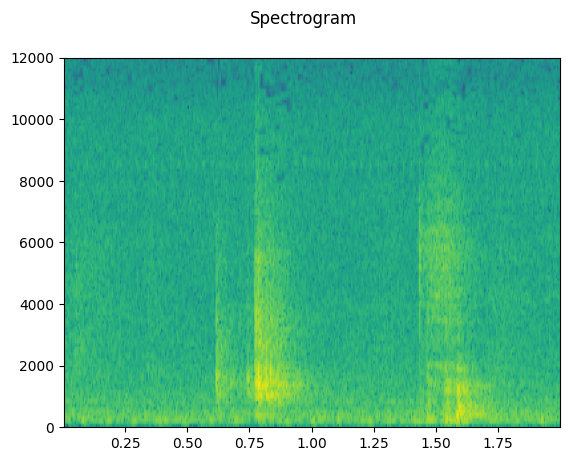

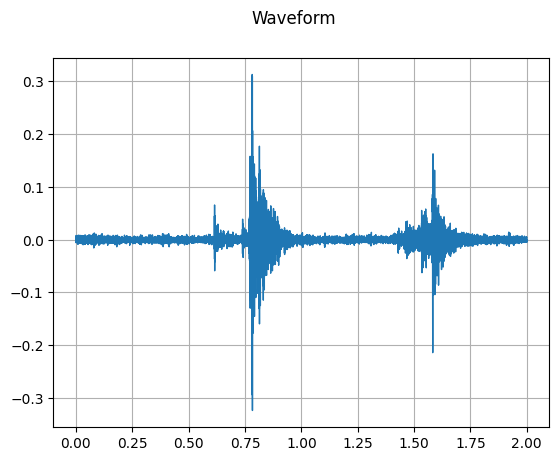

(None, None)

In [13]:
plot_specgram(sample, 24000), plot_waveform(sample, 24000)

In [51]:
for i in range(100):
    print("i:", np.random.binomial(n=1, p=0.3))

i: 0
i: 0
i: 1
i: 1
i: 0
i: 0
i: 1
i: 0
i: 1
i: 0
i: 0
i: 0
i: 0
i: 0
i: 0
i: 0
i: 0
i: 0
i: 0
i: 1
i: 0
i: 1
i: 1
i: 0
i: 0
i: 0
i: 0
i: 0
i: 1
i: 0
i: 0
i: 0
i: 0
i: 0
i: 0
i: 0
i: 0
i: 0
i: 1
i: 0
i: 1
i: 1
i: 0
i: 0
i: 0
i: 1
i: 0
i: 0
i: 1
i: 1
i: 1
i: 1
i: 0
i: 0
i: 0
i: 0
i: 0
i: 0
i: 0
i: 0
i: 1
i: 0
i: 0
i: 0
i: 0
i: 0
i: 0
i: 1
i: 0
i: 0
i: 0
i: 1
i: 0
i: 1
i: 0
i: 1
i: 0
i: 0
i: 1
i: 1
i: 0
i: 1
i: 0
i: 0
i: 1
i: 1
i: 0
i: 0
i: 0
i: 1
i: 1
i: 0
i: 0
i: 0
i: 1
i: 0
i: 1
i: 0
i: 0
i: 0
